In [5]:
from django_for_jupyter import init_django
init_django()

In [42]:
import pandas as pd
import os
from django.conf import settings
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import GridSearchCV, train_test_split
from surprise.accuracy import rmse
from surprise import dump

def clean_pretrain_data(df, min_book_ratings=3):
    """
    Lightly clean the pretrain data to remove noise while preserving most data.
    """
    original_rows = len(df)
    print(f"Step 0: Original rows: {original_rows}")
    
    # Step 1: Remove invalid ratings
    df = df[df['rating'].between(1, 5)]
    print(f"Step 1: Rows after removing invalid ratings: {len(df)}")
    
    # Step 2: Remove duplicates
    df = df.drop_duplicates(subset=['user_id', 'book_id'], keep='last')
    print(f"Step 2: Rows after removing duplicates: {len(df)}")
    
    # Step 3: Filter sparse books
    book_ratings = df.groupby('book_id').size()
    df = df[df['book_id'].isin(book_ratings[book_ratings >= min_book_ratings].index)]
    print(f"Step 3: Rows after filtering books (>= {min_book_ratings} ratings): {len(df)}")
    
    # Skip normalization to preserve rating diversity
    print("\nRating distribution after cleaning:")
    print(df['rating'].value_counts().sort_index())
    
    return df

def optimize_svd_params(file_path):
    try:
        # Load and clean data
        df = pd.read_csv(file_path)
        # df_cleaned = clean_pretrain_data(df, min_book_ratings=3)
        
        # Prepare data for Surprise
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)
        
        # Define parameter grid
        param_grid = {
            'n_factors': [20, 50, 100, 150, 200],
            'n_epochs': [10, 20, 30, 40],
            'lr_all': [0.001, 0.002, 0.005, 0.007, 0.01],
            'reg_all': [0.01, 0.02, 0.05, 0.1, 0.2]
        }
        
        # Run GridSearchCV
        gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
        gs.fit(data)
        
        # Print best parameters and RMSE
        print(f"Best RMSE: {gs.best_score['rmse']}")
        print(f"Best parameters: {gs.best_params['rmse']}")
        
        # Train final model with best parameters
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        best_params = gs.best_params['rmse']
        model = SVDpp(**best_params, random_state=42)
        model.fit(trainset)
        
        # Evaluate on test set
        predictions = model.test(testset)
        final_rmse = rmse(predictions, verbose=True)
        
        # Save model
        model_file = os.path.join(settings.BASE_DIR, 'models', 'svdpp_optimized.pkl')
        dump.dump(model_file, algo=model)
        
        return model, final_rmse, gs.best_params['rmse']
    
    except FileNotFoundError:
        print(f"Error: {file_path} not found")
        return None, None, None
    except Exception as e:
        print(f"Error during optimization: {str(e)}")
        return None, None, None

if __name__ == "__main__":
    file_path = os.path.join(settings.BASE_DIR, 'data', 'PretrainData.csv')
    model, rmse_score, best_params = optimize_svd_params(file_path)
    if model:
        print(f"Final model trained. RMSE: {rmse_score}")
        print(f"Best parameters: {best_params}")

Best RMSE: 1.1012115515363234
Best parameters: {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}
RMSE: 1.1261
Final model trained. RMSE: 1.1261287963986537
Best parameters: {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


In [84]:
import pandas as pd
import os
from django.conf import settings
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV, train_test_split
from surprise.accuracy import rmse, mae
from surprise import dump
import time
from collections import defaultdict
import numpy as np
def clean_pretrain_data(df, min_book_ratings=3, output_path=None):
    """
    Clean and mean-center the pretrain data, save to output_path if specified.
    """
    original_rows = len(df)
    print(f"Step 0: Original rows: {original_rows}")
    
    # Step 1: Remove invalid ratings
    df = df[df['rating'].between(1, 5)]
    print(f"Step 1: Rows after removing invalid ratings: {len(df)}")
    
    # Step 2: Remove duplicates
    df = df.drop_duplicates(subset=['user_id', 'book_id'], keep='last')
    print(f"Step 2: Rows after removing duplicates: {len(df)}")
    
    # Step 3: Filter sparse books
    book_ratings = df.groupby('book_id').size()
    df = df[df['book_id'].isin(book_ratings[book_ratings >= min_book_ratings].index)]
    print(f"Step 3: Rows after filtering books (>= {min_book_ratings} ratings): {len(df)}")
    
    # Step 4: Mean-center ratings (no clipping)
    user_counts = df.groupby('user_id').size().rename('user_count')
    user_means = df.groupby('user_id')['rating'].mean().rename('user_mean')
    global_mean = df['rating'].mean()
    df = df.join(user_counts, on='user_id').join(user_means, on='user_id')
    df['user_mean'] = df['user_mean'].where(df['user_count'] >= 3, global_mean)
    df['rating_normalized'] = df['rating'] - df['user_mean']
    df = df[['user_id', 'book_id', 'rating', 'rating_normalized', 'user_mean']]
    
    print("\nRating distribution after mean-centering:")
    print(df['rating_normalized'].describe())
    print(df['rating_normalized'].value_counts(bins=5))
    
    # Save cleaned data
    if output_path:
        df_cleaned = df[['user_id', 'book_id', 'rating_normalized']].rename(columns={'rating_normalized': 'rating'})
        df_cleaned.to_csv(output_path, index=False)
        print(f"Cleaned data saved to {output_path}")
    
    return df

def get_top_n(predictions, n=10):
    """
    Get top-N recommendations for each user.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    for uid in top_n:
        top_n[uid].sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = top_n[uid][:n]
    return top_n

def optimize_svd_params(file_path, output_clean_path, eval_output_path):
    start_time = time.time()
    try:
        print("1. Starting data loading...")
        df = pd.read_csv(file_path)
        print(f"   Loaded data shape: {df.shape}")
        
        print("\n2. Cleaning data...")
        df_cleaned = clean_pretrain_data(df, min_book_ratings=3, output_path=output_clean_path)
        print(f"   Cleaned data shape: {df_cleaned.shape}")
        
        print("\n3. Preparing Surprise dataset...")
        reader = Reader(rating_scale=(-4, 4))
        data = Dataset.load_from_df(df_cleaned[['user_id', 'book_id', 'rating_normalized']], reader)
        print("   Dataset prepared successfully")
        
        print("\n4. Starting GridSearchCV...")
        param_grid = {
            'n_factors': [150, 200, 250],
            'n_epochs': [25, 30, 35],
            'lr_all': [0.003, 0.005, 0.007],
            'reg_all': [0.01, 0.02, 0.05]
        }
        gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
        gs.fit(data)
        print("   GridSearchCV completed")
        
        print("\n5. Best parameters found:")
        print(f"   RMSE: {gs.best_score['rmse']}")
        print(f"   Parameters: {gs.best_params['rmse']}")
        
        print("\n6. Splitting data...")
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        print(f"   Test set size: {len(testset)}")
        
        print("\n7. Training final model...")
        best_params = gs.best_params['rmse']
        model = SVD(**best_params, random_state=42)
        model.fit(trainset)
        print("   Model training completed")
        
        print("\n8. Creating user_mean dictionary...")
        user_mean_dict = df_cleaned.groupby('user_id')['user_mean'].first().to_dict()
        print(f"   Number of users in dictionary: {len(user_mean_dict)}")
        
        print("\n9. Making predictions...")
        test_predictions = []
        for i, (uid, iid, r_ui) in enumerate(testset):
            if i % 1000 == 0:  # Log progress every 1000 predictions
                print(f"   Processing prediction {i}/{len(testset)}")
            
            try:
                pred = model.predict(uid, iid)
                user_mean = user_mean_dict.get(uid, df_cleaned['user_mean'].mean())
                true_r_orig = r_ui + user_mean
                est_orig = pred.est + user_mean
                test_predictions.append((uid, iid, true_r_orig, est_orig))
            except Exception as e:
                print(f"   Error in prediction {i}: uid={uid}, iid={iid}")
                print(f"   Error details: {str(e)}")
                raise
        
        print(f"\n10. Calculating metrics for {len(test_predictions)} predictions...")
        true_ratings = [p[2] for p in test_predictions]
        pred_ratings = [p[3] for p in test_predictions]
        
        rmse_score = np.sqrt(np.mean([(true - pred) ** 2 for true, pred in zip(true_ratings, pred_ratings)]))
        mae_score = np.mean([abs(true - pred) for true, pred in zip(true_ratings, pred_ratings)])
        
        print(f"   RMSE: {rmse_score:.4f}")
        print(f"   MAE: {mae_score:.4f}")
        
        print("\n11. Calculating precision and recall...")
        print("   Preparing predictions for precision/recall calculation...")
        precision_predictions = [(p[0], p[1], p[2], p[3], None) for p in test_predictions]
        print(f"   Number of predictions for P/R: {len(precision_predictions)}")
        
        try:
            precision_at_10, recall_at_10 = evaluate_precision_recall(
                precision_predictions,
                n=10,
                threshold=4.0
            )
            print(f"   Precision@10: {precision_at_10:.4f}")
            print(f"   Recall@10: {recall_at_10:.4f}")
        except Exception as e:
            print("   Error in precision/recall calculation:")
            print(f"   {str(e)}")
            raise

        print("\n12. Saving results...")
        eval_results = {
            'RMSE': rmse_score,
            'MAE': mae_score,
            'Precision@10': precision_at_10,
            'Recall@10': recall_at_10,
            'Best_params': best_params,
            'Runtime_seconds': time.time() - start_time
        }
        
        pd.DataFrame([eval_results]).to_csv(eval_output_path, index=False)
        print(f"   Results saved to {eval_output_path}")
        
        import pickle
        # Thêm phần lưu model
        print("\n13. Saving trained model...")
        model_path = os.path.join(settings.BASE_DIR, 'models', 'pretrain_svd_model.pkl')
        model_info = {
            'model': model,
            'best_params': best_params,
            'user_mean_dict': user_mean_dict,
            'metrics': {
                'rmse': rmse_score,
                'mae': mae_score,
                'precision@10': precision_at_10,
                'recall@10': recall_at_10
            },
            'training_time': time.time() - start_time
        }
        
        # Tạo thư mục models nếu chưa tồn tại
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        # Lưu model và thông tin liên quan
        with open(model_path, 'wb') as f:
            pickle.dump(model_info, f)
        print(f"   Model and related info saved to: {model_path}")
        
        
        print("\n144. Analyzing prediction distribution...")
        pred_df = pd.DataFrame(pred_ratings, columns=['predicted_rating'])
        print(pred_df['predicted_rating'].describe())
        
        return model, rmse_score, best_params
        
    except Exception as e:
        print("\nERROR OCCURRED!")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        print("\nFull traceback:")
        import traceback
        traceback.print_exc()
        return None, None, None

def evaluate_precision_recall(predictions, n=10, threshold=4.0):
    """
    Calculate precision@N and recall@N.
    """
    print(f"Starting precision/recall calculation with {len(predictions)} predictions")
    print(f"Parameters: n={n}, threshold={threshold}")
    
    # Group predictions by user
    user_pred_dict = defaultdict(list)
    user_true_dict = defaultdict(list)
    
    print("Grouping predictions by user...")
    for i, (uid, iid, true_r, est, _) in enumerate(predictions):
        if i % 10000 == 0:  # Log progress
            print(f"Processing prediction {i}/{len(predictions)}")
        user_pred_dict[uid].append((iid, est))
        if true_r >= threshold:
            user_true_dict[uid].append(iid)
    
    print(f"Number of users: {len(user_pred_dict)}")
    
    precisions = []
    recalls = []
    
    print("Calculating precision and recall for each user...")
    for i, uid in enumerate(user_pred_dict):
        if i % 1000 == 0:  # Log progress
            print(f"Processing user {i}/{len(user_pred_dict)}")
            
        # Get top-N predictions
        user_preds = sorted(user_pred_dict[uid], key=lambda x: x[1], reverse=True)[:n]
        pred_items = set(iid for iid, _ in user_preds)
        
        # Get relevant items
        rel_items = set(user_true_dict[uid])
        
        if len(rel_items) > 0:
            # Calculate precision and recall
            n_rel_and_rec = len(pred_items & rel_items)
            precision = n_rel_and_rec / min(n, len(pred_items)) if len(pred_items) > 0 else 0
            recall = n_rel_and_rec / len(rel_items) if len(rel_items) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
    
    print(f"Number of users with relevant items: {len(precisions)}")
    
    # Calculate averages
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    
    print(f"Final results: P@{n}={avg_precision:.4f}, R@{n}={avg_recall:.4f}")
    
    return avg_precision, avg_recall

if __name__ == "__main__":
    file_path = os.path.join(settings.BASE_DIR, 'data', 'PretrainData.csv')
    output_clean_path = os.path.join(settings.BASE_DIR, 'data', 'PretrainData_clean.csv')
    eval_output_path = os.path.join(settings.BASE_DIR, 'data', 'evaluation_results.csv')
    model, rmse_score, best_params = optimize_svd_params(file_path, output_clean_path, eval_output_path)
    if model:
        print(f"Final model trained. RMSE: {rmse_score}")
        print(f"Best parameters: {best_params}")

1. Starting data loading...
   Loaded data shape: (3706, 3)

2. Cleaning data...
Step 0: Original rows: 3706
Step 1: Rows after removing invalid ratings: 3706
Step 2: Rows after removing duplicates: 3658
Step 3: Rows after filtering books (>= 3 ratings): 3567

Rating distribution after mean-centering:
count    3567.000000
mean       -0.004557
std         1.144464
min        -3.339781
25%        -0.339781
50%         0.660219
75%         0.660219
max         1.333333
Name: rating_normalized, dtype: float64
(0.399, 1.333]                   2365
(-0.536, 0.399]                   562
(-1.471, -0.536]                  283
(-3.3449999999999998, -2.405]     198
(-2.405, -1.471]                  159
Name: count, dtype: int64
Cleaned data saved to C:\Users\thait\LABS\NC\cit_book-web\data\PretrainData_clean.csv
   Cleaned data shape: (3567, 5)

3. Preparing Surprise dataset...
   Dataset prepared successfully

4. Starting GridSearchCV...
   GridSearchCV completed

5. Best parameters found:
   RM

In [ ]:
import pandas as pd
import os
from django.conf import settings

def map_pretrain_to_outputs(pretrain_clean_path, book_path, user_path, rating_path, output_dir):
    """
    Map cleaned PretrainData to other CSV files and create new output files.
    
    Parameters:
    - pretrain_clean_path: Path to PretrainData_clean.csv
    - book_path: Path to extract_match_book.csv
    - user_path: Path to AmazonUser.csv
    - rating_path: Path to AmazonRating.csv
    - output_dir: Directory to save output files
    """
    try:
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Read cleaned pretrain data
        print("Reading PretrainData_clean.csv...")
        df_pretrain = pd.read_csv(pretrain_clean_path)
        print(f"PretrainData_clean.csv: {len(df_pretrain)} rows")
        print("Sample user_id from PretrainData_clean.csv:")
        print(df_pretrain['user_id'].head())
        
        # Remove 'AMZ_' prefix from user_id to get id
        df_pretrain['id'] = df_pretrain['user_id'].str.replace('AMZ_', '', regex=False)
        # Convert id to numeric (if possible)
        df_pretrain['id'] = pd.to_numeric(df_pretrain['id'], errors='coerce')
        if df_pretrain['id'].isna().any():
            print(f"Warning: {df_pretrain['id'].isna().sum()} user_ids could not be converted to id")
        
        # Read AmazonUser.csv to create mapping
        print("\nReading AmazonUser.csv...")
        df_users = pd.read_csv(user_path)
        print(f"AmazonUser.csv: {len(df_users)} rows")
        print("Sample id, amazon_user_id from AmazonUser.csv:")
        print(df_users[['id', 'amazon_user_id']].head())
        
        # Create mapping from id to amazon_user_id
        user_id_map = df_users.set_index('id')['amazon_user_id'].to_dict()
        
        # Map id to amazon_user_id in PretrainData_clean.csv
        df_pretrain['amazon_user_id'] = df_pretrain['id'].map(user_id_map)
        if df_pretrain['amazon_user_id'].isna().any():
            print(f"Warning: {df_pretrain['amazon_user_id'].isna().sum()} ids not found in AmazonUser.csv")
            print("Sample missing ids:", df_pretrain[df_pretrain['amazon_user_id'].isna()]['id'].unique()[:5])
        
        # Get valid amazon_user_id and book_id
        valid_amazon_user_ids = set(df_pretrain['amazon_user_id'].dropna())
        valid_book_ids = set(df_pretrain['book_id'])
        print(f"Valid amazon_user_ids: {len(valid_amazon_user_ids)}")
        print(f"Valid book_ids: {len(valid_book_ids)}")
        
        # Process extract_match_book.csv
        print("\nProcessing extract_match_book.csv...")
        df_books = pd.read_csv(book_path)
        original_book_rows = len(df_books)
        df_books_clean = df_books[df_books['book_id'].isin(valid_book_ids)]
        book_output_path = os.path.join(output_dir, 'extract_match_book_clean.csv')
        df_books_clean.to_csv(book_output_path, index=False)
        print(f"extract_match_book_clean.csv: {len(df_books_clean)} rows (from {original_book_rows})")
        print(f"Saved to {book_output_path}")
        
        # Process AmazonUser.csv
        print("\nProcessing AmazonUser.csv...")
        original_user_rows = len(df_users)
        df_users_clean = df_users[df_users['amazon_user_id'].isin(valid_amazon_user_ids)]
        user_output_path = os.path.join(output_dir, 'AmazonUser_clean.csv')
        df_users_clean.to_csv(user_output_path, index=False)
        print(f"AmazonUser_clean.csv: {len(df_users_clean)} rows (from {original_user_rows})")
        print(f"Saved to {user_output_path}")
        
        # Process AmazonRating.csv
        print("\nProcessing AmazonRating.csv...")
        df_ratings = pd.read_csv(rating_path)
        original_rating_rows = len(df_ratings)
        print("Sample amazon_user_id, book_id from AmazonRating.csv:")
        print(df_ratings[['amazon_user_id', 'book_id']].head())
        
        # Filter by amazon_user_id and book_id
        df_ratings_clean = df_ratings[
            (df_ratings['amazon_user_id'].isin(valid_amazon_user_ids)) & 
            (df_ratings['book_id'].isin(valid_book_ids))
        ]
        # Ensure exact match with PretrainData_clean.csv
        df_ratings_clean = df_ratings_clean.merge(
            df_pretrain[['amazon_user_id', 'book_id']],
            on=['amazon_user_id', 'book_id'],
            how='inner'
        )
        df_ratings_clean = df_ratings_clean[['amazon_user_id', 'book_id', 'rating', 'timestamp']]
        rating_output_path = os.path.join(output_dir, 'AmazonRating_clean.csv')
        df_ratings_clean.to_csv(rating_output_path, index=False)
        print(f"AmazonRating_clean.csv: {len(df_ratings_clean)} rows (from {original_rating_rows})")
        print(f"Saved to {rating_output_path}")
        
        return True
    
    except FileNotFoundError as e:
        print(f"Error: File not found - {str(e)}")
        return False
    except Exception as e:
        print(f"Error during mapping: {str(e)}")
        return False

if __name__ == "__main__":
    # Define file paths
    pretrain_clean_path = os.path.join(settings.BASE_DIR, 'data', 'PretrainData_clean.csv')
    book_path = os.path.join(settings.BASE_DIR, 'data', 'exact_matched_books.csv')
    user_path = os.path.join(settings.BASE_DIR, 'data', 'AmazonUser.csv')
    rating_path = os.path.join(settings.BASE_DIR, 'data', 'AmazonRating.csv')
    output_dir = os.path.join(settings.BASE_DIR, 'data')
    
    # Run mapping
    success = map_pretrain_to_outputs(
        pretrain_clean_path=pretrain_clean_path,
        book_path=book_path,
        user_path=user_path,
        rating_path=rating_path,
        output_dir=output_dir
    )
    
    if success:
        print("\nAll output files created successfully!")
    else:
        print("\nFailed to create output files.")

Original data shape: (3706, 3)

Initial rating distribution:
rating
1.0     209
2.0     169
3.0     293
4.0     546
5.0    2489
Name: count, dtype: int64

Shape after filtering: (81, 3)

Final rating distribution:
rating
1.000000     3
1.000000     1
1.000000     1
1.023830     2
1.375226     2
1.750451     2
2.125677    10
2.477072     2
2.500902     1
4.350090     4
5.000000    53
Name: count, dtype: int64

Sparsity: 96.8458%
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1662  1.2377  1.2654  1.2783  1.0370  1.1969  0.0889  
MAE (testset)     1.0074  1.0308  1.0716  1.1336  0.8839  1.0255  0.0827  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    

Cross-validation results:
Mean RMSE: 1.1969 (+/- 0.0889)
Mean MAE: 1.0255 (+/- 0.0827)
RMSE: 1.0988
MAE:  0.9326

Detailed evaluation metr

C:\Users\thait\AppData\Local\Temp\ipykernel_25392\4184920200.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('user_id').apply(normalize_user_ratings)


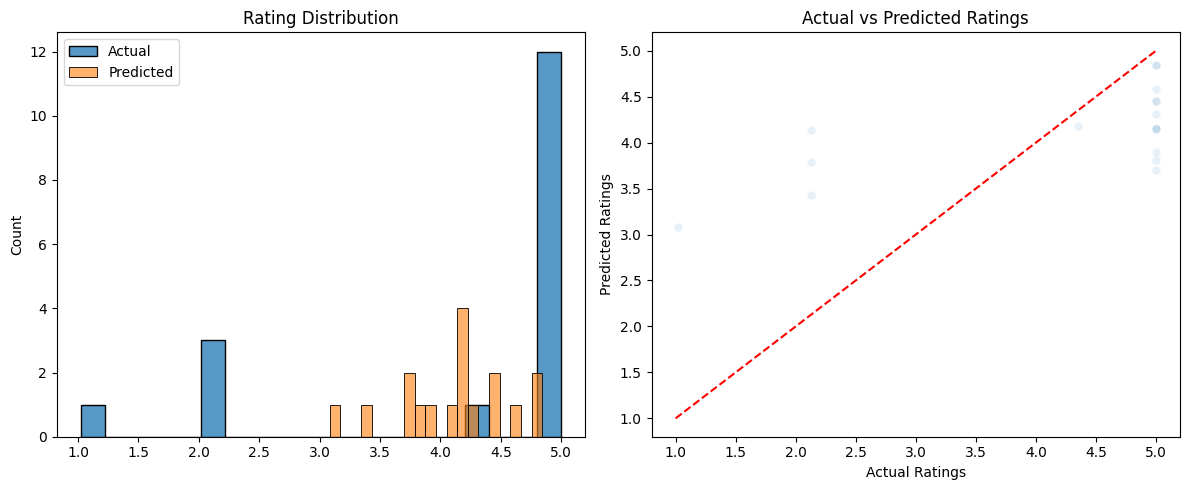

In [65]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

def clean_and_normalize_data(df, min_user_ratings=3, min_book_ratings=5):
    """
    Chuẩn hóa dữ liệu và in các thống kê
    """
    print("Original data shape:", df.shape)
    
    # 1. Analyze initial distribution
    print("\nInitial rating distribution:")
    print(df['rating'].value_counts().sort_index())
    
    # 2. Filter users and books
    user_ratings = df.groupby('user_id').size()
    book_ratings = df.groupby('book_id').size()
    
    valid_users = user_ratings[user_ratings >= min_user_ratings].index
    valid_books = book_ratings[book_ratings >= min_book_ratings].index
    
    df = df[df['user_id'].isin(valid_users) & df['book_id'].isin(valid_books)]
    print("\nShape after filtering:", df.shape)

    # 3. Z-score normalization per user
    def normalize_user_ratings(group):
        mean = group['rating'].mean()
        std = group['rating'].std()
        if std == 0:
            return group
        group['rating'] = (group['rating'] - mean) / std
        return group
    
    df = df.groupby('user_id').apply(normalize_user_ratings)
    
    # 4. Min-Max scaling to [1,5]
    min_rating = df['rating'].min()
    max_rating = df['rating'].max()
    df['rating'] = 1 + 4 * (df['rating'] - min_rating) / (max_rating - min_rating)
    
    # 5. Print statistics
    print("\nFinal rating distribution:")
    print(df['rating'].value_counts().sort_index())
    print("\nSparsity: {:.4f}%".format(
        (1 - len(df) / (len(valid_users) * len(valid_books))) * 100
    ))
    
    return df

def evaluate_model(predictions, k=10):
    """
    Comprehensive evaluation with multiple metrics
    """
    # Basic metrics
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    # Prepare data for ranking metrics
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    # Calculate Precision@K and Recall@K
    precisions = []
    recalls = []
    ndcg_scores = []

    for uid, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(reverse=True)
        
        # Ensure we have enough ratings
        if len(user_ratings) < 2:
            continue
        
        # Get top-K recommended items (limit to available ratings)
        k_adjusted = min(k, len(user_ratings))
        top_k_est = [1 if est >= 3.5 else 0 for est, _ in user_ratings[:k_adjusted]]
        true_ratings = [1 if true_r >= 3.5 else 0 for _, true_r in user_ratings[:k_adjusted]]
        
        if sum(true_ratings) > 0:  # Only calculate if there are relevant items
            precisions.append(precision_score(true_ratings, top_k_est, zero_division=0))
            recalls.append(recall_score(true_ratings, top_k_est, zero_division=0))
            
            # Calculate NDCG only if we have more than 1 rating
            if len(true_ratings) > 1:
                try:
                    gain_true = [2**r - 1 for r in true_ratings]
                    gain_pred = [2**p - 1 for p in top_k_est]
                    ndcg = ndcg_score([gain_true], [gain_pred])
                    if not np.isnan(ndcg):
                        ndcg_scores.append(ndcg)
                except Exception:
                    continue

    metrics = {
        'RMSE': rmse,
        
    }
    
    return metrics

def train_and_evaluate_svd(df, n_factors=100, cv_folds=5):
    """
    Train SVD model with cross-validation and detailed evaluation
    """
    # Prepare data
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)
    
    # Define model with optimized parameters
    model = SVD(
        n_factors=n_factors,
        biased=True,
        lr_all=0.005,
        reg_all=0.02,
        n_epochs=30,
        random_state=42
    )
    
    try:
        # Cross-validation
        cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], 
                                  cv=cv_folds, verbose=True)
        
        print("\nCross-validation results:")
        print(f"Mean RMSE: {np.mean(cv_results['test_rmse']):.4f} (+/- {np.std(cv_results['test_rmse']):.4f})")
        print(f"Mean MAE: {np.mean(cv_results['test_mae']):.4f} (+/- {np.std(cv_results['test_mae']):.4f})")
        
        # Train-test split for detailed evaluation
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        model.fit(trainset)
        predictions = model.test(testset)
        
        # Detailed evaluation
        metrics = evaluate_model(predictions)
        print("\nDetailed evaluation metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Visualize rating distribution
        actual_ratings = [pred.r_ui for pred in predictions]
        predicted_ratings = [pred.est for pred in predictions]
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(actual_ratings, bins=20, label='Actual')
        sns.histplot(predicted_ratings, bins=20, label='Predicted', alpha=0.6)
        plt.title('Rating Distribution')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=actual_ratings, y=predicted_ratings, alpha=0.1)
        plt.plot([1, 5], [1, 5], 'r--')
        plt.title('Actual vs Predicted Ratings')
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        
        plt.tight_layout()
        plt.show()
        
        return model, metrics
    except Exception as e:
        print(f"Error during training and evaluation: {str(e)}")
        return None, None

def optimize_svd_params(file_path, output_clean_path, eval_output_path):
    start_time = time.time()
    try:
        # Load and clean data
        df = pd.read_csv(file_path)
        df_cleaned = clean_pretrain_data(df, min_book_ratings=3, output_path=output_clean_path)
        
        # Prepare data for Surprise
        reader = Reader(rating_scale=(-4, 4))
        data = Dataset.load_from_df(df_cleaned[['user_id', 'book_id', 'rating_normalized']], reader)
        
        # Define parameter grid
        param_grid = {
            'n_factors': [150, 200, 250],
            'n_epochs': [25, 30, 35],
            'lr_all': [0.003, 0.005, 0.007],
            'reg_all': [0.01, 0.02, 0.05]
        }
        
        # Run GridSearchCV
        gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
        gs.fit(data)
        
        # Print best parameters and RMSE
        print(f"Best RMSE (CV): {gs.best_score['rmse']}")
        print(f"Best parameters: {gs.best_params['rmse']}")
        
        # Train final model with best parameters
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        best_params = gs.best_params['rmse']
        model = SVD(**best_params, random_state=42)
        model.fit(trainset)
        
        # Evaluate on test set
        predictions = []
        # Tạo mapping từ index sang user_mean
        user_mean_dict = dict(zip(range(len(df_cleaned)), df_cleaned['user_mean']))
        
        for uid, iid, r_ui in testset:
            est = model.predict(uid, iid).est
            # Lấy user_mean từ dictionary thay vì df_cleaned.iloc
            user_mean = df_cleaned[df_cleaned['user_id'] == uid]['user_mean'].iloc[0]
            true_r_orig = r_ui + user_mean
            est_orig = est + user_mean
            predictions.append((uid, iid, true_r_orig, est_orig, None))
        
        rmse_score = rmse(predictions, verbose=True)
        mae_score = mae(predictions, verbose=True)
        precision_at_10, recall_at_10 = evaluate_precision_recall(predictions, n=10, threshold=4.0)
        print(f"Precision@10: {precision_at_10}")
        print(f"Recall@10: {recall_at_10}")
        
        # Save model
        model_file = os.path.join(settings.BASE_DIR, 'models', 'svd_mean_centered.pkl')
        dump.dump(model_file, algo=model)
        
        # Save evaluation results
        eval_results = {
            'RMSE': rmse_score,
            'MAE': mae_score,
            'Precision@10': precision_at_10,
            'Recall@10': recall_at_10,
            'Best_n_factors': best_params['n_factors'],
            'Best_n_epochs': best_params['n_epochs'],
            'Best_lr_all': best_params['lr_all'],
            'Best_reg_all': best_params['reg_all'],
            'Rows_after_cleaning': len(df_cleaned),
            'Runtime_seconds': time.time() - start_time
        }
        eval_df = pd.DataFrame([eval_results])
        eval_df.to_csv(eval_output_path, index=False)
        print(f"Evaluation results saved to {eval_output_path}")
        
        # Check prediction distribution (original scale)
        pred_ratings = [pred[3] for pred in predictions]  # est_orig
        print("\nPredicted rating distribution (original scale):")
        print(pd.Series(pred_ratings).describe())
        print(pd.Series(pred_ratings).value_counts(bins=5))
        
        return model, rmse_score, best_params
    except FileNotFoundError:
        print(f"Error: {file_path} not found")
        return None, None, None
    except Exception as e:
        print(f"Error during optimization: {str(e)}")
        return None, None, None

# Main execution
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('data/PretrainData.csv')
    
    # Clean and normalize
    df_normalized = clean_and_normalize_data(df)
    
    # Train and evaluate model
    model, metrics = train_and_evaluate_svd(df_normalized)
    
    # Save model and metrics
    import pickle
    with open('models/enhanced_svd_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    with open('models/evaluation_metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)

In [85]:
import pandas as pd
import os
from django.conf import settings
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from surprise import dump
from home.models import Rating, Book
from django.contrib.auth.models import User

def prepare_finetune_data(output_path):
    """
    Extract data from Rating model and prepare for fine-tuning.
    Save to output_path.
    """
    print("Extracting data from Rating model...")
    ratings = Rating.objects.all().select_related('user', 'book')
    data = []
    for rating in ratings:
        data.append({
            'user_id': rating.user.id,  # Use auth_user.id as user_id
            'book_id': rating.book.book_id,  # Assume Book model has book_id
            'rating': rating.rating,
            'timestamp': rating.created_at
        })
    df_finetune = pd.DataFrame(data)
    print(f"Fine-tune data: {len(df_finetune)} rows")
    
    # Save raw fine-tune data
    df_finetune.to_csv(output_path, index=False)
    print(f"Fine-tune data saved to {output_path}")
    return df_finetune

def standardize_finetune_data(df_finetune, global_mean, min_ratings=3, output_path=None):
    """
    Standardize fine-tune data by mean-centering ratings.
    Save to output_path if specified.
    """
    print("Standardizing fine-tune data...")
    
    # Calculate user counts and means
    user_counts = df_finetune.groupby('user_id').size().rename('user_count')
    user_means = df_finetune.groupby('user_id')['rating'].mean().rename('user_mean')
    df_finetune = df_finetune.join(user_counts, on='user_id').join(user_means, on='user_id')
    
    # Use global_mean for users with few ratings
    df_finetune['user_mean'] = df_finetune['user_mean'].where(df_finetune['user_count'] >= min_ratings, global_mean)
    df_finetune['rating_normalized'] = df_finetune['rating'] - df_finetune['user_mean']
    
    # Keep relevant columns
    df_finetune = df_finetune[['user_id', 'book_id', 'rating_normalized']].rename(columns={'rating_normalized': 'rating'})
    
    print("\nRating distribution after mean-centering:")
    print(df_finetune['rating'].describe())
    
    # Save standardized data
    if output_path:
        df_finetune.to_csv(output_path, index=False)
        print(f"Standardized fine-tune data saved to {output_path}")
    
    return df_finetune

def finetune_svd_model(pretrain_path, finetune_path, model_path, output_model_path):
    """
    Fine-tune SVD model with new data.
    
    Parameters:
    - pretrain_path: Path to PretrainData_clean.csv
    - finetune_path: Path to raw fine-tune data CSV
    - model_path: Path to pretrain_svd_model.pkl
    - output_model_path: Path to save fine-tuned model
    """
    try:
        # Load pretrain data
        print("Loading pretrain data...")
        df_pretrain = pd.read_csv(pretrain_path)
        print(f"Pretrain data: {len(df_pretrain)} rows")
        
        # Calculate global_mean from pretrain data (for standardization)
        pretrain_raw_path = os.path.join(settings.BASE_DIR, 'data', 'AmazonRating_clean.csv')
        df_pretrain_raw = pd.read_csv(pretrain_raw_path)
        global_mean = df_pretrain_raw['rating'].mean()
        print(f"Global mean rating: {global_mean}")
        
        # Load fine-tune data
        print("\nLoading fine-tune data...")
        df_finetune = pd.read_csv(finetune_path)
        print(f"Fine-tune data: {len(df_finetune)} rows")
        
        # Standardize fine-tune data
        df_finetune_std = standardize_finetune_data(
            df_finetune,
            global_mean=global_mean,
            output_path=os.path.join(settings.BASE_DIR, 'data', 'finetune_data_std.csv')
        )
        
        # Combine pretrain and fine-tune data
        print("\nCombining pretrain and fine-tune data...")
        df_combined = pd.concat([df_pretrain, df_finetune_std], ignore_index=True)
        print(f"Combined data: {len(df_combined)} rows")
        
        # Prepare data for Surprise
        reader = Reader(rating_scale=(-4, 4))
        data = Dataset.load_from_df(df_combined[['user_id', 'book_id', 'rating']], reader)
        
        # Load pretrained model
        print("\nLoading pretrained model...")
        _, model = dump.load(model_path)
        
        # Update model parameters for fine-tuning
        model.lr_all = 0.001  # Lower learning rate for fine-tuning
        model.n_epochs = 10   # Fewer epochs to avoid overfitting
        
        # Train on combined data
        print("Fine-tuning model...")
        trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        model.fit(trainset)
        
        # Evaluate on test set
        predictions = model.test(testset)
        rmse_score = rmse(predictions, verbose=True)
        mae_score = mae(predictions, verbose=True)
        
        # Save fine-tuned model
        dump.dump(output_model_path, algo=model)
        print(f"Fine-tuned model saved to {output_model_path}")
        
        # Check prediction distribution
        pred_ratings = [pred.est for pred in predictions]
        print("\nPredicted rating distribution (normalized scale):")
        print(pd.Series(pred_ratings).describe())
        
        return model, rmse_score, mae_score
    
    except FileNotFoundError as e:
        print(f"Error: File not found - {str(e)}")
        return None, None, None
    except Exception as e:
        print(f"Error during fine-tuning: {str(e)}")
        return None, None, None

if __name__ == "__main__":
    # Define file paths
    pretrain_path = os.path.join(settings.BASE_DIR, 'data', 'PretrainData_clean.csv')
    finetune_path = os.path.join(settings.BASE_DIR, 'data', 'finetune_data.csv')
    model_path = os.path.join(settings.BASE_DIR, 'models', 'pretrain_svd_model.pkl')
    output_model_path = os.path.join(settings.BASE_DIR, 'models', 'finetuned_svd_model.pkl')
    
    # Prepare fine-tune data from Rating model
    df_finetune = prepare_finetune_data(finetune_path)
    
    # Fine-tune model
    model, rmse_score, mae_score = finetune_svd_model(
        pretrain_path=pretrain_path,
        finetune_path=finetune_path,
        model_path=model_path,
        output_model_path=output_model_path
    )
    
    if model:
        print(f"\nFine-tuning completed. RMSE: {rmse_score}, MAE: {mae_score}")
    else:
        print("\nFine-tuning failed.")

Extracting data from Rating model...
Fine-tune data: 0 rows
Fine-tune data saved to C:\Users\thait\LABS\NC\cit_book-web\data\finetune_data.csv
Loading pretrain data...
Pretrain data: 3567 rows
Global mean rating: 4.340066408411732

Loading fine-tune data...
Error during fine-tuning: No columns to parse from file

Fine-tuning failed.


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992


In [ ]:
if __name__ == "__main__":
    # Initial training
    model, rmse_score = train_initial_model2()
    if model:
        print(f"Initial model trained. RMSE: {rmse_score}")

RMSE: 1.1228
Initial model trained. RMSE: 1.1227936235253992
